Human drug label data was downloaded from [OpenFDA](https://open.fda.gov/data/downloads/) as a set of 12 zipped JSON files.

This is a much smaller download than getting the full release from [Daily Med](https://dailymed.nlm.nih.gov/dailymed/spl-resources-all-drug-labels.cfm).

In [1]:
import zipfile
import json
import pandas as pd
import os
from collections import Counter
import os.path
import re


def load_data_from_zip(my_zip_file):
    archive = zipfile.ZipFile(DATA_DIR + my_zip_file, 'r')
    my_json_file = my_zip_file.replace('.zip', '')
    return json.loads(archive.read(my_json_file).decode("utf-8"))


def flatten_list(my_list):
    # flatten a list into a single string, if it is a list.
    try:
        flattened = '::'.join(my_list)
    except:
        print(r"ERROR flattening {my_list}")
        flattened = my_list
    return flattened


def extract_dataframe(results):
    data_rows = []
    for res in results:
        row = {}
        # attributes from openfda
        for attr in ['brand_name', 'generic_name', 'product_type']:
            if attr in res['openfda']:
                row[attr] = flatten_list(res['openfda'][attr])
            else:
                row[attr] = ''
        # top level attributes
        for attr in ['description', 'indications_and_usage', 'mechanism_of_action']:
            if attr in res:
                row[attr] = flatten_list(res[attr])
            else:
                row[attr] = ''

        data_rows.append(row)

    return pd.DataFrame(data_rows)


DATA_DIR = '/Users/rmhorton/Downloads/openFDA/'

ZIP_FILES = sorted([f for f in os.listdir(DATA_DIR) if f.endswith('.zip')])
ZIP_FILES

['drug-label-0001-of-0012.json.zip',
 'drug-label-0002-of-0012.json.zip',
 'drug-label-0003-of-0012.json.zip',
 'drug-label-0004-of-0012.json.zip',
 'drug-label-0005-of-0012.json.zip',
 'drug-label-0006-of-0012.json.zip',
 'drug-label-0007-of-0012.json.zip',
 'drug-label-0008-of-0012.json.zip',
 'drug-label-0009-of-0012.json.zip',
 'drug-label-0010-of-0012.json.zip',
 'drug-label-0011-of-0012.json.zip',
 'drug-label-0012-of-0012.json.zip']

## Exploring drug lable archives

In [2]:
labels = load_data_from_zip("drug-label-0001-of-0012.json.zip")
len(labels) # 2 keys, 'meta' and 'results'
labels['meta']

{'disclaimer': 'Do not rely on openFDA to make decisions regarding medical care. While we make every effort to ensure that data is accurate, you should assume all results are unvalidated. We may limit or otherwise restrict your access to the API in line with our Terms of Service.',
 'terms': 'https://open.fda.gov/terms/',
 'license': 'https://open.fda.gov/license/',
 'last_updated': '2024-11-12',
 'results': {'skip': 0, 'limit': 20000, 'total': 235810}}

In [3]:
len(labels['results']) # 20000
list(labels['results'][0].keys())

['spl_product_data_elements',
 'boxed_warning',
 'indications_and_usage',
 'dosage_and_administration',
 'dosage_forms_and_strengths',
 'dosage_forms_and_strengths_table',
 'contraindications',
 'warnings_and_cautions',
 'adverse_reactions',
 'adverse_reactions_table',
 'drug_interactions',
 'use_in_specific_populations',
 'pregnancy',
 'pediatric_use',
 'geriatric_use',
 'overdosage',
 'description',
 'clinical_pharmacology',
 'mechanism_of_action',
 'pharmacodynamics',
 'pharmacokinetics',
 'nonclinical_toxicology',
 'carcinogenesis_and_mutagenesis_and_impairment_of_fertility',
 'clinical_studies',
 'clinical_studies_table',
 'how_supplied',
 'how_supplied_table',
 'information_for_patients',
 'package_label_principal_display_panel',
 'set_id',
 'id',
 'effective_time',
 'version',
 'openfda']

In [4]:
# The top level information is in the 'openfda' object
for res in labels['results'][0:10]:
    key = 'openfda' # 'spl_product_data_elements' 'mechanism_of_action' 'openfda' 'package_label_principal_display_panel'  'description' 'information_for_patients'
    if key in res:
        print(key, ': ', res[key])
    # print(res['id'], "\t", res['description'], "\n")

openfda :  {'application_number': ['ANDA209010'], 'brand_name': ['Amlodipine and Olmesartan Medoxomil'], 'generic_name': ['AMLODIPINE AND OLMESARTAN MEDOXOMIL'], 'manufacturer_name': ['ScieGen Pharmaceuticals, Inc'], 'product_ndc': ['50228-365', '50228-366', '50228-367', '50228-368'], 'product_type': ['HUMAN PRESCRIPTION DRUG'], 'route': ['ORAL'], 'substance_name': ['AMLODIPINE BESYLATE', 'OLMESARTAN MEDOXOMIL'], 'rxcui': ['730861', '730866', '730869', '730872'], 'spl_id': ['1666c9c9-9d30-4155-e063-6394a90afde9'], 'spl_set_id': ['c531fceb-09aa-492b-a5a3-2b004e9eadda'], 'package_ndc': ['50228-365-30', '50228-365-90', '50228-365-10', '50228-366-30', '50228-366-90', '50228-366-10', '50228-367-30', '50228-367-90', '50228-367-10', '50228-368-30', '50228-368-90', '50228-368-10'], 'is_original_packager': [True], 'upc': ['0350228367103', '0350228367301', '0350228366106', '0350228365109', '0350228368100', '0350228366908', '0350228365307', '0350228366304', '0350228368902', '0350228365901', '0350

## Drug label data frames

In [5]:
DRUGS_FILE = "human_prescription_drugs.xlsx"

if os.path.exists(DRUGS_FILE):
    human_prescription_drugs_df = pd.read_excel(DRUGS_FILE)
else:
    # Process all zip files

    human_prescription_drugs = []
    for zfile in ZIP_FILES:
        print(zfile)
        file_number = int(re.sub(r"drug-label-([0-9]+).*", r"\1", zfile))
        labels = load_data_from_zip(zfile)
        results_df = extract_dataframe(labels['results'])
        human_prescription_drugs.append(results_df[results_df['product_type'] == 'HUMAN PRESCRIPTION DRUG'])
        excel_file = f"drug_label_{file_number:02d}.xlsx"
        results_df.to_excel(excel_file)

    human_prescription_drugs_df = pd.concat(human_prescription_drugs).reset_index(drop=True)
    human_prescription_drugs_df.to_excel(DRUGS_FILE)


human_prescription_drugs_df

,Unnamed: 0,brand_name,generic_name,product_type,description,indications_and_usage,mechanism_of_action
0,0,Amlodipine and Olmesartan Medoxomil,AMLODIPINE AND OLMESARTAN MEDOXOMIL,HUMAN PRESCRIPTION DRUG,11 DESCRIPTION Amlodipine and olmesartan medox...,1 INDICATIONS AND USAGE Amlodipine and olmesar...,12.1 Mechanism of Action Amlodipine and olmesa...
1,1,ARTHROTEC,DICLOFENAC SODIUM AND MISOPROSTOL,HUMAN PRESCRIPTION DRUG,11 DESCRIPTION ARTHROTEC is a combination prod...,1 INDICATIONS AND USAGE ARTHROTEC is indicated...,12.1 Mechanism of Action ARTHROTEC is a combin...
2,2,"Polyethylene Glycol 3350, Sodium Chloride, Sod...","POLYETHYLENE GLYCOL 3350, SODIUM CHLORIDE, SOD...",HUMAN PRESCRIPTION DRUG,11 DESCRIPTION For oral solution: Each 5 liter...,1 INDICATIONS AND USAGE Polyethylene glycol 33...,NaN
3,3,Irbesartan and Hydrochlorothiazide,IRBESARTAN AND HYDROCHLOROTHIAZIDE,HUMAN PRESCRIPTION DRUG,11 DESCRIPTION Irbesartan and Hydrochlorothiaz...,1 INDICATIONS AND USAGE Irbesartan and hydroch...,12.1 Mechanism of Action Irbesartan Angiotensi...
4,4,Potassium Phosphates,POTASSIUM PHOSPHATES,HUMAN PRESCRIPTION DRUG,"11 DESCRIPTION Potassium Phosphates Injection,...",1 INDICATIONS AND USAGE Potassium Phosphates I...,12.1 Mechanism of Action Phosphorus in the for...
...,...,...,...,...,...,...,...
36801,36801,Oxycodone Hydrochloride and Acetaminophen,OXYCODONE HYDROCHLORIDE AND ACETAMINOPHEN,HUMAN PRESCRIPTION DRUG,DESCRIPTION Oxycodone Hydrochloride and Acetam...,INDICATIONS & USAGE Oxycodone and Acetaminophe...,NaN
36802,36802,Anaprox DS,NAPROXEN SODIUM,HUMAN PRESCRIPTION DRUG,"11 DESCRIPTION NAPROSYN (naproxen) tablets, EC...","1 INDICATIONS AND USAGE NAPROSYN Tablets, EC-N...",12.1 Mechanism of Action Naproxen has analgesi...
36803,36803,Hydrocodone Bitartrate and Homatropine Methylb...,HYDROCODONE BITARTRATE AND HOMATROPINE METHYLB...,HUMAN PRESCRIPTION DRUG,11 DESCRIPTION Hydrocodone bitartrate and homa...,1 INDICATIONS AND USAGE Hydrocodone bitartrate...,12.1 Mechanism of Action Hydrocodone Hydrocodo...
36804,36804,"dextroamphetamine saccharate, amphetamine aspa...","DEXTROAMPHETAMINE SACCHARATE, AMPHETAMINE ASPA...",HUMAN PRESCRIPTION DRUG,"11 DESCRIPTION Dextroamphetamine Saccharate, A...",1 INDICATIONS AND USAGE Dextroamphetamine Sacc...,12.1 Mechanism of Action Amphetamines are non-...


# Featurize text columns

In [6]:
FEATURIZED_FILE = 'human_prescription_drugs_featurized.parquet'

if os.path.exists(FEATURIZED_FILE):
    human_prescription_drugs_df = pd.read_parquet(FEATURIZED_FILE)
else:  # 31 min on Bob's M3 Mac
    from sentence_transformers import SentenceTransformer
    sentxformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    for text_col in ['description', 'indications_and_usage', 'mechanism_of_action']:
        print(f"featurizing {text_col}")
        human_prescription_drugs_df[text_col + '_vector'] = sentxformer.encode(human_prescription_drugs_df[text_col].values).astype('float32').tolist()
    human_prescription_drugs_df.to_parquet(FEATURIZED_FILE)


human_prescription_drugs_df

,brand_name,generic_name,product_type,description,indications_and_usage,mechanism_of_action,description_vector,indications_and_usage_vector,mechanism_of_action_vector
0,Amlodipine and Olmesartan Medoxomil,AMLODIPINE AND OLMESARTAN MEDOXOMIL,HUMAN PRESCRIPTION DRUG,11 DESCRIPTION Amlodipine and olmesartan medox...,1 INDICATIONS AND USAGE Amlodipine and olmesar...,12.1 Mechanism of Action Amlodipine and olmesa...,"[-0.0251484252512455, -0.014093315228819847, 0...","[-0.04058678075671196, 0.015312662348151207, 0...","[-0.029752785339951515, -0.0015405130106955767..."
1,ARTHROTEC,DICLOFENAC SODIUM AND MISOPROSTOL,HUMAN PRESCRIPTION DRUG,11 DESCRIPTION ARTHROTEC is a combination prod...,1 INDICATIONS AND USAGE ARTHROTEC is indicated...,12.1 Mechanism of Action ARTHROTEC is a combin...,"[0.02258964814245701, -0.02370976097881794, -0...","[0.026246052235364914, -0.0003164233057759702,...","[0.020150907337665558, -0.0012751225149258971,..."
2,"Polyethylene Glycol 3350, Sodium Chloride, Sod...","POLYETHYLENE GLYCOL 3350, SODIUM CHLORIDE, SOD...",HUMAN PRESCRIPTION DRUG,11 DESCRIPTION For oral solution: Each 5 liter...,1 INDICATIONS AND USAGE Polyethylene glycol 33...,,"[0.05875419080257416, -0.01822586916387081, -0...","[0.04296257719397545, -0.02611582726240158, -0...","[-0.012503336183726788, 0.06143886223435402, -..."
3,Irbesartan and Hydrochlorothiazide,IRBESARTAN AND HYDROCHLOROTHIAZIDE,HUMAN PRESCRIPTION DRUG,11 DESCRIPTION Irbesartan and Hydrochlorothiaz...,1 INDICATIONS AND USAGE Irbesartan and hydroch...,12.1 Mechanism of Action Irbesartan Angiotensi...,"[0.018642738461494446, -0.061663269996643066, ...","[0.01213595550507307, -0.013446979224681854, 0...","[0.006609566509723663, -0.045228831470012665, ..."
4,Potassium Phosphates,POTASSIUM PHOSPHATES,HUMAN PRESCRIPTION DRUG,"11 DESCRIPTION Potassium Phosphates Injection,...",1 INDICATIONS AND USAGE Potassium Phosphates I...,12.1 Mechanism of Action Phosphorus in the for...,"[0.029501350596547127, -0.08191590756177902, -...","[0.03445522114634514, -0.04430317133665085, 0....","[-0.007063195109367371, 0.019696714356541634, ..."
...,...,...,...,...,...,...,...,...,...
36801,Oxycodone Hydrochloride and Acetaminophen,OXYCODONE HYDROCHLORIDE AND ACETAMINOPHEN,HUMAN PRESCRIPTION DRUG,DESCRIPTION Oxycodone Hydrochloride and Acetam...,INDICATIONS & USAGE Oxycodone and Acetaminophe...,,"[-0.0014800369972363114, 0.023205861449241638,...","[-0.0018607164965942502, -0.01076608058065176,...","[-0.012503336183726788, 0.06143886223435402, -..."
36802,Anaprox DS,NAPROXEN SODIUM,HUMAN PRESCRIPTION DRUG,"11 DESCRIPTION NAPROSYN (naproxen) tablets, EC...","1 INDICATIONS AND USAGE NAPROSYN Tablets, EC-N...",12.1 Mechanism of Action Naproxen has analgesi...,"[0.010343536734580994, -0.021375570446252823, ...","[0.0074096317403018475, 0.01403836440294981, -...","[-0.006560009904205799, -0.0036851167678833008..."
36803,Hydrocodone Bitartrate and Homatropine Methylb...,HYDROCODONE BITARTRATE AND HOMATROPINE METHYLB...,HUMAN PRESCRIPTION DRUG,11 DESCRIPTION Hydrocodone bitartrate and homa...,1 INDICATIONS AND USAGE Hydrocodone bitartrate...,12.1 Mechanism of Action Hydrocodone Hydrocodo...,"[0.022935671731829643, -0.03710448741912842, -...","[0.02439817227423191, -0.014275806024670601, 0...","[0.020335186272859573, 0.007597180083394051, 0..."
36804,"dextroamphetamine saccharate, amphetamine aspa...","DEXTROAMPHETAMINE SACCHARATE, AMPHETAMINE ASPA...",HUMAN PRESCRIPTION DRUG,"11 DESCRIPTION Dextroamphetamine Saccharate, A...",1 INDICATIONS AND USAGE Dextroamphetamine Sacc...,12.1 Mechanism of Action Amphetamines are non-...,"[0.016110626980662346, -0.013666011393070221, ...","[-0.010057266801595688, -0.05343985930085182, ...","[-0.04683513194322586, -0.019234921783208847, ..."


# Cluster by three different embeddings

In [7]:
from collections import Counter;

def add_cluster_cols(df, embedding_col='description', prefix='cluster', letters='ABCDE', max_threshold=1):
    from scipy.cluster.hierarchy import ward, fcluster
    from scipy.spatial.distance import pdist
    import math

    # cluster the sentence vectors at various levels
    X = df[embedding_col].tolist()
    y = pdist(X, metric='cosine')
    z = ward(y)

    for i in range(len(letters)):
        letter = letters[i]
        col_name = f'{prefix}_{letter}'
        cluster_id = fcluster(z, max_threshold/2**i, criterion='distance')
        digits = 1 + math.floor(math.log10(max(cluster_id)))
        df[col_name] = [letter + str(cid).zfill(digits) + f'_{prefix}' for cid in cluster_id]

    cluster_cols = [c for c in df.columns if c.startswith(f'{prefix}_')]
    return df.sort_values(by=cluster_cols)


In [8]:
CLUSTERED_FILE = "human_prescription_drugs_clustered_v2.parquet"

TARGETS = ["description", "indications_and_usage", "mechanism_of_action"]

if os.path.exists(CLUSTERED_FILE):
   human_prescription_drugs_df = pd.read_parquet(CLUSTERED_FILE)
else:  # 27 min

   for target in TARGETS:
      human_prescription_drugs_df = add_cluster_cols(human_prescription_drugs_df, 
                                                      embedding_col=f"{target}_vector", 
                                                      prefix=f"{target}_cluster", 
                                                      letters='ABCDEFGHI', 
                                                      max_threshold=16)

   human_prescription_drugs_df.to_parquet(CLUSTERED_FILE)

In [9]:
human_prescription_drugs_df.columns
# TARGETS[0] 'indications_and_usage', 'mechanism_of_action'

Index(['brand_name', 'generic_name', 'product_type', 'description',
       'indications_and_usage', 'mechanism_of_action', 'description_vector',
       'indications_and_usage_vector', 'mechanism_of_action_vector',
       'description_cluster_A', 'description_cluster_B',
       'description_cluster_C', 'description_cluster_D',
       'description_cluster_E', 'description_cluster_F',
       'description_cluster_G', 'description_cluster_H',
       'description_cluster_I', 'indications_and_usage_cluster_A',
       'indications_and_usage_cluster_B', 'indications_and_usage_cluster_C',
       'indications_and_usage_cluster_D', 'indications_and_usage_cluster_E',
       'indications_and_usage_cluster_F', 'indications_and_usage_cluster_G',
       'indications_and_usage_cluster_H', 'indications_and_usage_cluster_I',
       'mechanism_of_action_cluster_A', 'mechanism_of_action_cluster_B',
       'mechanism_of_action_cluster_C', 'mechanism_of_action_cluster_D',
       'mechanism_of_action_cluster_E

In [10]:
target = TARGETS[0]
cluster_names = [c for c in sorted(human_prescription_drugs_df.columns) if c.startswith(f"{target}_cluster_")]
cluster_names

['description_cluster_A',
 'description_cluster_B',
 'description_cluster_C',
 'description_cluster_D',
 'description_cluster_E',
 'description_cluster_F',
 'description_cluster_G',
 'description_cluster_H',
 'description_cluster_I']

In [11]:
subcluster_counts = {}
for target in TARGETS:
    subcluster_counts[target] = {}
    cluster_names = [c for c in sorted(human_prescription_drugs_df.columns) if c.startswith(f"{target}_cluster_")]
    for cluster_col in cluster_names:
        num_clusters = len(Counter(human_prescription_drugs_df[cluster_col]))
        subcluster_counts[target][cluster_col] = num_clusters

subcluster_counts

{'description': {'description_cluster_A': 6,
  'description_cluster_B': 35,
  'description_cluster_C': 137,
  'description_cluster_D': 389,
  'description_cluster_E': 809,
  'description_cluster_F': 1550,
  'description_cluster_G': 2960,
  'description_cluster_H': 4281,
  'description_cluster_I': 5600},
 'indications_and_usage': {'indications_and_usage_cluster_A': 9,
  'indications_and_usage_cluster_B': 41,
  'indications_and_usage_cluster_C': 144,
  'indications_and_usage_cluster_D': 411,
  'indications_and_usage_cluster_E': 985,
  'indications_and_usage_cluster_F': 2168,
  'indications_and_usage_cluster_G': 3856,
  'indications_and_usage_cluster_H': 4836,
  'indications_and_usage_cluster_I': 5713},
 'mechanism_of_action': {'mechanism_of_action_cluster_A': 8,
  'mechanism_of_action_cluster_B': 26,
  'mechanism_of_action_cluster_C': 83,
  'mechanism_of_action_cluster_D': 248,
  'mechanism_of_action_cluster_E': 519,
  'mechanism_of_action_cluster_F': 982,
  'mechanism_of_action_cluster_

In [12]:
level_A_counts = {}
for target in TARGETS:
    level_A_counts[target] = Counter(human_prescription_drugs_df[f'{target}_cluster_A'])


level_A_counts

{'description': Counter({'A2_description_cluster': 15168,
          'A4_description_cluster': 10242,
          'A6_description_cluster': 3526,
          'A5_description_cluster': 3088,
          'A3_description_cluster': 2969,
          'A1_description_cluster': 1813}),
 'indications_and_usage': Counter({'A9_indications_and_usage_cluster': 8220,
          'A7_indications_and_usage_cluster': 6748,
          'A4_indications_and_usage_cluster': 4741,
          'A5_indications_and_usage_cluster': 4222,
          'A3_indications_and_usage_cluster': 4028,
          'A2_indications_and_usage_cluster': 2683,
          'A8_indications_and_usage_cluster': 2473,
          'A6_indications_and_usage_cluster': 2195,
          'A1_indications_and_usage_cluster': 1496}),
 'mechanism_of_action': Counter({'A1_mechanism_of_action_cluster': 17238,
          'A4_mechanism_of_action_cluster': 5264,
          'A2_mechanism_of_action_cluster': 3248,
          'A8_mechanism_of_action_cluster': 3088,
          

In [13]:
non_blank_fractions = {}
for target in TARGETS:
    non_blank = sum(human_prescription_drugs_df[target] != '') # 34993
    total = len(human_prescription_drugs_df) # 36806
    non_blank_fractions[target] = non_blank/total

non_blank_fractions

{'description': 0.9507417268923545,
 'indications_and_usage': 0.9593544530783025,
 'mechanism_of_action': 0.5316524479704396}

## Sort the drugs by each of the three text columns (TARGETS)

Here I am sorting by the subclusters for each target. Alternatively, you could sort them in Excel, but you need to be sure to sort by all of the subclusters for a give target in order from large to small.

I write out the sorted data without the vectors, because vectors make the files too big.

In [14]:
def sort_by_target(df, target):
    print(f"sorting by '{target}'")
    cluster_names = [c for c in sorted(df.columns) if c.startswith(f"{target}_cluster_")]
    sorted_by_target = df[df[target] != ''].sort_values(cluster_names)
    return sorted_by_target

sorted_by = {}
for target in TARGETS:
    sorted_by[target] = sort_by_target(human_prescription_drugs_df, target)

sorting by 'description'
sorting by 'indications_and_usage'
sorting by 'mechanism_of_action'


In [15]:
for target in TARGETS:
       df = sorted_by[target]
       base_cols = ['brand_name', 'generic_name', 'description', 'indications_and_usage', 'mechanism_of_action']
       cluster_cols = [c for c in df if f"{target}_cluster" in c and 'vector' not in c]
       df[[*base_cols, *cluster_cols]].to_excel(f"human_prescription_drugs_sorted_by_{target}.xlsx")


# Predict MeSH terms

In [16]:
START_HERE = True

if START_HERE:
    CLUSTERED_FILE = "human_prescription_drugs_clustered_v2.parquet"
    human_prescription_drugs_df = pd.read_parquet(CLUSTERED_FILE)

In [17]:
import pandas as pd
import numpy as np
from ast import literal_eval

MODEL_DATA_FILE = "model_data_1014_MeSH_terms.parquet"

model_data = pd.read_parquet(MODEL_DATA_FILE) 

# vectors are strings, so they need to be evaluated
model_data['beta_unit_vector'] = [literal_eval(v) for v in model_data['beta_unit_vector']]

In [32]:
# Concept matrix
C = np.array([v for v in model_data['beta_unit_vector']])  # 1014, 768

# Usage matrix
U = np.array([v for v in human_prescription_drugs_df['indications_and_usage_vector']])  # 36806, 768

# Mechanism matrix
M = np.array([v for v in human_prescription_drugs_df['mechanism_of_action_vector']]) # 36806, 768

# Usage scores
U_scores = np.matmul(U, C.T)
# U_scores.shape # (36806, 1014)

# Mechanism scores
M_scores = np.matmul(M, C.T)

In [19]:
def scores_to_flags(X, std_threshold=2):
    column_means = np.mean(X, axis=0)
    column_stds = np.std(X, axis=0)
    thresholds = (column_means + std_threshold * column_stds)

    Flags = np.apply_along_axis(lambda row: np.greater(row, thresholds).astype(int), 1, X)

    return pd.DataFrame(Flags, columns=model_data['name'])

std_threshold=3

Flags_usage = scores_to_flags(U_scores, std_threshold)
Flags_mechanism = scores_to_flags(M_scores, std_threshold)

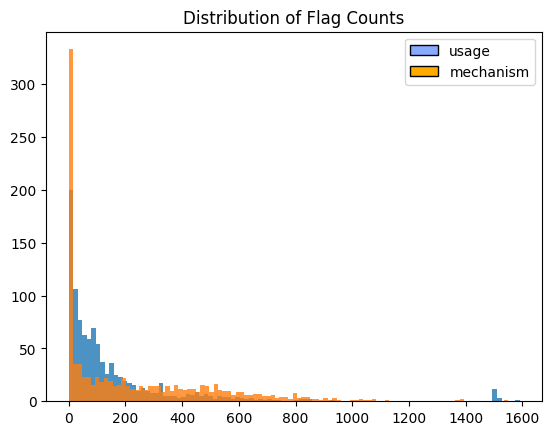

In [20]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

_ = plt.hist(np.sum(Flags_usage, axis=0), bins=100, alpha=0.8)

_ = plt.hist(np.sum(Flags_mechanism, axis=0), bins=100, alpha=0.8)
plt.title("Distribution of Flag Counts")

#create legend
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['#8af', '#fa0']]
labels= ["usage", "mechanism"]
plt.legend(handles, labels)

In [21]:
def get_topN(my_scores, N=5):
    colnames = model_data['name']

    topN_ind = np.argpartition(my_scores, -N)[-N:]        # find indexes for top N scores
    topN_ind = topN_ind[np.argsort(my_scores[topN_ind])]  # sort them

    df = pd.DataFrame({'term': [colnames[x] for x in topN_ind],
                       'score': my_scores[topN_ind]}).sort_values('score', ascending=False)
    
    return '::'.join([f"{row['term']} ({row['score']:0.3f})" for row in df.to_records()])


M_terms = np.apply_along_axis(get_topN, 1, M_scores)
U_terms = np.apply_along_axis(get_topN, 1, U_scores)

human_prescription_drugs_df['mechanism_of_action_terms'] = M_terms
human_prescription_drugs_df['indications_and_usage_terms'] = U_terms

human_prescription_drugs_df

,brand_name,generic_name,product_type,description,indications_and_usage,mechanism_of_action,description_vector,indications_and_usage_vector,mechanism_of_action_vector,description_cluster_A,...,mechanism_of_action_cluster_B,mechanism_of_action_cluster_C,mechanism_of_action_cluster_D,mechanism_of_action_cluster_E,mechanism_of_action_cluster_F,mechanism_of_action_cluster_G,mechanism_of_action_cluster_H,mechanism_of_action_cluster_I,mechanism_of_action_terms,indications_and_usage_terms
25,Oxygen,OXYGEN,HUMAN PRESCRIPTION DRUG,,,,"[-0.012503336183726788, 0.06143886223435402, -...","[-0.012503336183726788, 0.06143886223435402, -...","[-0.012503336183726788, 0.06143886223435402, -...",A1_description_cluster,...,B01_mechanism_of_action_cluster,C01_mechanism_of_action_cluster,D001_mechanism_of_action_cluster,E001_mechanism_of_action_cluster,F001_mechanism_of_action_cluster,G0001_mechanism_of_action_cluster,H0001_mechanism_of_action_cluster,I0001_mechanism_of_action_cluster,"A549 Cells (0.190)::Models, Neurological (0.17...","A549 Cells (0.190)::Models, Neurological (0.17..."
32,LOSARTAN POTASSIUM AND HYDROCHLOROTHIAZIDE,LOSARTAN POTASSIUM AND HYDROCHLOROTHIAZIDE,HUMAN PRESCRIPTION DRUG,,,,"[-0.012503336183726788, 0.06143886223435402, -...","[-0.012503336183726788, 0.06143886223435402, -...","[-0.012503336183726788, 0.06143886223435402, -...",A1_description_cluster,...,B01_mechanism_of_action_cluster,C01_mechanism_of_action_cluster,D001_mechanism_of_action_cluster,E001_mechanism_of_action_cluster,F001_mechanism_of_action_cluster,G0001_mechanism_of_action_cluster,H0001_mechanism_of_action_cluster,I0001_mechanism_of_action_cluster,"A549 Cells (0.190)::Models, Neurological (0.17...","A549 Cells (0.190)::Models, Neurological (0.17..."
55,Oxygen,OXYGEN,HUMAN PRESCRIPTION DRUG,,,,"[-0.012503336183726788, 0.06143886223435402, -...","[-0.012503336183726788, 0.06143886223435402, -...","[-0.012503336183726788, 0.06143886223435402, -...",A1_description_cluster,...,B01_mechanism_of_action_cluster,C01_mechanism_of_action_cluster,D001_mechanism_of_action_cluster,E001_mechanism_of_action_cluster,F001_mechanism_of_action_cluster,G0001_mechanism_of_action_cluster,H0001_mechanism_of_action_cluster,I0001_mechanism_of_action_cluster,"A549 Cells (0.190)::Models, Neurological (0.17...","A549 Cells (0.190)::Models, Neurological (0.17..."
56,Oxygen,OXYGEN,HUMAN PRESCRIPTION DRUG,,,,"[-0.012503336183726788, 0.06143886223435402, -...","[-0.012503336183726788, 0.06143886223435402, -...","[-0.012503336183726788, 0.06143886223435402, -...",A1_description_cluster,...,B01_mechanism_of_action_cluster,C01_mechanism_of_action_cluster,D001_mechanism_of_action_cluster,E001_mechanism_of_action_cluster,F001_mechanism_of_action_cluster,G0001_mechanism_of_action_cluster,H0001_mechanism_of_action_cluster,I0001_mechanism_of_action_cluster,"A549 Cells (0.190)::Models, Neurological (0.17...","A549 Cells (0.190)::Models, Neurological (0.17..."
73,Oxygen,OXYGEN,HUMAN PRESCRIPTION DRUG,,,,"[-0.012503336183726788, 0.06143886223435402, -...","[-0.012503336183726788, 0.06143886223435402, -...","[-0.012503336183726788, 0.06143886223435402, -...",A1_description_cluster,...,B01_mechanism_of_action_cluster,C01_mechanism_of_action_cluster,D001_mechanism_of_action_cluster,E001_mechanism_of_action_cluster,F001_mechanism_of_action_cluster,G0001_mechanism_of_action_cluster,H0001_mechanism_of_action_cluster,I0001_mechanism_of_action_cluster,"A549 Cells (0.190)::Models, Neurological (0.17...","A549 Cells (0.190)::Models, Neurological (0.17..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29063,HYDROXYUREA,HYDROXYUREA,HUMAN PRESCRIPTION DRUG,"11 DESCRIPTION Hydroxyurea capsules, USP are a...",1 INDICATIONS AND USAGE Hydroxyurea capsules a...,12.1 Mechanism of Action The precise mechanism...,"[0.027366094291210175, 0.003358685178682208, 0...","[0.042039286345243454, 0.018111564218997955, 0...","[0.04220213741064072, -0.024259774014353752, 0...",A4_descript

In [22]:
keep_cols = ['brand_name', 'generic_name', 'indications_and_usage_terms', 'mechanism_of_action_terms']
human_prescription_drugs_df[keep_cols].to_excel('human_prescription_drugs_predicted_MeSH_terms.xlsx')

## 

# Favorite drugs

In [23]:
favorite_drugs = ['naproxen', 'venlafaxine', 'botulinum']

# How many generic names match each pattern? How many are there of each?
generic_name_counts = {}
for favorite_drug in favorite_drugs:
    tag_flags = [favorite_drug.lower() in n.lower() for n in human_prescription_drugs_df['generic_name']]
    generic_name_counts[favorite_drug] = Counter(human_prescription_drugs_df.loc[ tag_flags, 'generic_name' ])

generic_name_counts

{'naproxen': Counter({'NAPROXEN': 149,
          'NAPROXEN SODIUM': 39,
          'NAPROXEN AND ESOMEPRAZOLE MAGNESIUM': 4,
          'SUMATRIPTAN AND NAPROXEN SODIUM': 3,
          'SUMATRIPTAN SUCCINATE AND NAPROXEN SODIUM': 2,
          'NAPROXEN , CAPSAICIN': 1,
          'NAPROXEN ORAL': 1}),
 'venlafaxine': Counter({'VENLAFAXINE HYDROCHLORIDE': 134,
          'VENLAFAXINE': 50,
          'DESVENLAFAXINE SUCCINATE': 21,
          'DESVENLAFAXINE': 19,
          'DESVENLAFAXINE ER': 2,
          'VENLAFAXINE HCL': 2,
          'VENLAFAXINE HCL ER': 2,
          'VENLAFAXINE HYDROCHLORIDE, EXTENDED RELEASE': 1}),
 'botulinum': Counter({'BOTULINUM TOXIN TYPE A': 3,
          'INCOBOTULINUMTOXINA': 2,
          'ONABOTULINUMTOXINA': 2,
          'RIMABOTULINUMTOXINB': 1,
          'PRABOTULINUM TOXIN TYPE A': 1,
          'LETIBOTULINUMTOXINA-WLBG': 1,
          'HUMAN BOTULINUM NEUROTOXIN A/B IMMUNE GLOBULIN': 1})}

In [24]:
# predicted MeSH terms for mechanism of action

favorite_drug_row = {'naproxen': 32000, 'botulinum': 27430, 'venlaflaxine': 22173, 'metformin':30000}

N = 10
for name, i in favorite_drug_row.items():
    my_scores = M_scores[i,]
    print(name, ': ', get_topN(my_scores, N), "\n")

naproxen :  Inflammation (0.396)::Inflammation Mediators (0.370)::Interleukin-6 (0.357)::Pain (0.336)::Anti-Inflammatory Agents (0.332)::Tumor Necrosis Factor-alpha (0.323)::Drug Synergism (0.312)::Pain Measurement (0.309)::Dose-Response Relationship, Drug (0.284)::Rats, Wistar (0.281) 

botulinum :  Rats, Wistar (0.354)::Spinal Cord (0.270)::Recombinant Proteins (0.255)::Nerve Tissue Proteins (0.250)::Inflammation (0.249)::Pain (0.246)::Axons (0.241)::Plant Extracts (0.235)::Carrier Proteins (0.234)::Protein Transport (0.232) 

venlaflaxine :  Rats, Wistar (0.303)::Dose-Response Relationship, Drug (0.295)::Depressive Disorder, Major (0.279)::Drug Synergism (0.268)::Neurogenesis (0.267)::NF-E2-Related Factor 2 (0.256)::Plant Extracts (0.250)::Depression (0.233)::Neuronal Plasticity (0.231)::Hippocampus (0.226) 

metformin :  Hypoglycemic Agents (0.521)::Diabetes Mellitus, Type 2 (0.493)::Insulin (0.389)::Glucose (0.361)::Blood Glucose (0.331)::Glycated Hemoglobin (0.314)::Obesity (0.30

In [25]:
# predicted MeSH terms for indications and usage

favorite_drug_row = {'naproxen': 32000, 'botulinum': 27430, 'venlaflaxine': 22173, 'metformin':30000}

N = 10
for name, i in favorite_drug_row.items():
    my_scores = U_scores[i,]
    print(name, ': ', get_topN(my_scores, N), "\n")

naproxen :  Dose-Response Relationship, Drug (0.268)::Arthritis, Rheumatoid (0.263)::Pharmaceutical Preparations (0.254)::Structure-Activity Relationship (0.252)::Drug Synergism (0.250)::Anti-Inflammatory Agents (0.241)::Molecular Structure (0.224)::Tumor Necrosis Factor-alpha (0.215)::Pain (0.209)::Pyrimidines (0.203) 

botulinum :  Pain (0.222)::Creatinine (0.218)::Double-Blind Method (0.213)::Recovery of Function (0.212)::Enzyme Inhibitors (0.212)::Exercise Therapy (0.210)::Malaria, Falciparum (0.204)::Stroke (0.204)::Plant Extracts (0.195)::Pneumonia, Viral (0.192) 

venlaflaxine :  Depression (0.316)::Dose-Response Relationship, Drug (0.302)::Depressive Disorder, Major (0.284)::Double-Blind Method (0.269)::Anxiety Disorders (0.264)::Medication Adherence (0.258)::Drug Therapy, Combination (0.230)::Stroke (0.221)::Pharmaceutical Preparations (0.219)::Drug Administration Schedule (0.214) 

metformin :  Diabetes Mellitus, Type 2 (0.423)::Hypoglycemic Agents (0.402)::Obesity (0.304)::G

In [26]:
import re

# botox_pat = re.compile('botulinum', re.IGNORECASE)
# np.where([botox_pat.search(n) is not None for n in human_prescription_drugs_df['generic_name']])

venlafaxine_pat = re.compile('venlafaxine', re.IGNORECASE)
venlaflaxine_flags = [venlafaxine_pat.search(n) is not None for n in human_prescription_drugs_df['generic_name']]
venlaflaxine_idx = np.where(venlaflaxine_flags)

venlaflaxine_idx[0]
# human_prescription_drugs_df['generic_name'].iloc[venlaflaxine_idx[0]]

array([  327,   834,  1158,  1187,  1273,  5464,  5465,  5466,  5467,
        5468,  5469,  5470,  5471,  5472,  5473,  5474,  5475,  5732,
        5733,  5734,  5735,  5736,  5737,  5738,  5739,  5740,  5741,
        5742,  5743,  5744,  5745,  5746,  5747,  5748,  5749,  5750,
        5751,  5752,  5753,  5754,  5755,  5756,  5757,  5758,  5759,
        5760,  5761,  5762,  5763,  5764,  5765,  5766,  5767,  5768,
        5769,  5770,  5771,  5772,  5773,  5774,  5775,  5776,  5777,
        5778,  5779,  5780,  5781,  5782,  5783,  5784,  5785,  5786,
        5787,  5788,  5789,  5790,  5791,  5792,  5793,  5794,  5795,
        5796,  5797,  5798,  5799,  5800,  5801,  5802,  5803,  5804,
        5805, 22036, 22037, 22038, 22039, 22040, 22041, 22042, 22043,
       22044, 22045, 22046, 22047, 22048, 22049, 22050, 22051, 22052,
       22053, 22054, 22055, 22056, 22057, 22058, 22059, 22060, 22061,
       22062, 22063, 22064, 22065, 22066, 22067, 22068, 22069, 22070,
       22071, 22072,

# Selected drug - MeSH term matrix

In [ ]:
## Representative drugs

# 'mechanism_of_action_cluster_D' contains 248 clusters; we want to select an example from each of these clusters.
# Note that 'D001_mechanism_of_action_cluster' is just the drugs that did not have a mechanism of action entry (empty string).
 
keep_cols = ['brand_name', 'generic_name', 'description', 'indications_and_usage', 'mechanism_of_action', 'mechanism_of_action_vector']
hpd_select = human_prescription_drugs_df.loc[human_prescription_drugs_df['mechanism_of_action_cluster_D'] != 'D001_mechanism_of_action_cluster'] \
    .groupby(['mechanism_of_action_cluster_D']) \
    .first()[keep_cols]

# Check that all selected drugs have unique generic names: 
# Counter(hpd_select['generic_name']).most_common()

# Mechanism matrix
M_selected = np.array([v for v in hpd_select['mechanism_of_action_vector']])


## Selected MeSH term models: keep only the 382 models that gave their own definition the highest score

model_definition_rank = pd.read_csv("~/Documents/conferences/BARUG/top_definitions_per_model.csv", index_col=0)[['term', 'own_rank']]

best_models = model_definition_rank[model_definition_rank['own_rank'] == 1]['term'].values

# best_models

best_model_data = model_data[[n in best_models for n in model_data['name']]]

# Concept matrix for selected models
C_selected = np.array([v for v in best_model_data['beta_unit_vector']])  # (382, 768)


## Filtered document-MeSH score table

,name,target,intercept,beta_scaling_factor,beta_unit_vector
9,Adolescent,D000293,-1.224337,8.427899,"[0.047813453, 0.009102658, 0.016244773, 0.0438..."
19,Surveys and Questionnaires,D011795,-2.142644,8.992003,"[0.01751007, 0.022083621, -0.00040007726, -0.0..."
22,Pregnancy,D011247,-2.636204,9.969393,"[-0.027534772, 0.051143065, -0.03869575, -0.07..."
23,"Child, Preschool",D002675,-2.300455,9.546321,"[0.03910592, 0.014169029, 0.004584004, 0.04243..."
25,"Disease Models, Animal",D004195,-2.658293,8.668046,"[0.010039889, 0.030918555, 0.030729048, -0.003..."
...,...,...,...,...,...
985,Choice Behavior,D002755,-2.179986,20.765812,"[-0.010562242, -0.007864507, -0.019593058, 0.0..."
994,Finland,D005387,-1.793915,23.437309,"[0.047281086, 0.062012013, -0.023434749, -0.01..."
996,Gastrointestinal Tract,D041981,-2.533759,9.208204,"[0.021532368, 0.013458192, 0.018784571, 0.0093..."
998,Axons,D001369,-3.604372,18.161688,"[-0.03225301, 0.01790441, 0.031443797, 0.03643..."


In [77]:
hpd_select['generic_name'].values

array(['CAROSPIR', 'DESMOPRESSIN ACETATE', 'ENALAPRILAT',
       'VALSARTAN AND HYDROCHLOROTHIAZIDE', 'EPLERENONE', 'SILDENAFIL',
       'SILDENAFIL CITRATE', 'ROFLUMILAST', 'DOXAZOSIN MESYLATE',
       'SOLIFENACIN SUCCINATE', 'OXYBUTYNIN',
       'AMLODIPINE BESYLATE AND OLMESARTAN MEDOXOMIL',
       'NICARDIPINE HYDROCHLORIDE', 'NITROGLYCERIN', 'AMMONIA N-13',
       'RANOLAZINE', 'DIGOXIN', 'DROXIDOPA', 'NEBIVOLOL HYDROCHLORIDE',
       'TREPROSTINIL', 'VERAPAMIL HYDROCHLORIDE',
       'DILTIAZEM HYDROCHLORIDE', 'PHENYLEPHRINE HYDROCHLORIDE',
       'EPHEDRINE SULFATE', 'ADENOSINE', 'IPRATROPIUM BROMIDE',
       'CARVEDILOL', 'PROPAFENONE HYDROCHLORIDE', 'SOTALOL HYDROCHLORIDE',
       'METOPROLOL SUCCINATE', 'QUETIAPINE FUMARATE', 'ASENAPINE',
       'CLOZAPINE', 'RISPERIDONE', 'LURASIDONE HYDROCHLORIDE',
       'BUPROPION HYDROCHLORIDE', 'CITALOPRAM', 'LITHIUM CARBONATE',
       'MIRTAZAPINE', 'FLUVOXAMINE MALEATE', 'SERTRALINE HYDROCHLORIDE',
       'PAROXETINE HYDROCHLORIDE', '

In [ ]:
S_selected = np.matmul(M_selected, C_selected.T)
S_df = pd.DataFrame(S_selected, columns=best_model_data['name'])

S_df['drug_generic_name'] = hpd_select['generic_name'].values
S_df = S_df.set_index('drug_generic_name')
S_df.to_excel("representative_drugs_selected_MeSH_term_scores.xlsx")
S_df


name,Adolescent,Surveys and Questionnaires,Pregnancy,"Child, Preschool","Disease Models, Animal",Mutation,Biomarkers,Time Factors,Gene Expression Profiling,China,...,Ultraviolet Rays,Anxiety Disorders,Neural Pathways,Cross Infection,Creatinine,Choice Behavior,Finland,Gastrointestinal Tract,Axons,Disinformation
drug_generic_name,,,,,,,,,,,,,,,,,,,,,
CAROSPIR,-0.093543,-0.031924,-0.035170,-0.066983,0.111412,-0.114402,0.055281,-0.060726,-0.048195,0.001927,...,-0.086483,0.013323,-0.029992,-0.046665,0.172654,-0.037436,-0.041945,-0.003107,0.024643,0.002299
DESMOPRESSIN ACETATE,-0.078966,-0.093075,0.016833,-0.130835,0.134544,-0.044066,0.194788,-0.169201,0.036254,-0.033074,...,-0.091422,-0.052027,-0.089103,-0.077045,0.262607,-0.065801,-0.051807,0.065559,-0.035707,-0.017547
ENALAPRILAT,-0.086330,-0.037007,0.002469,-0.063677,0.093905,-0.174500,0.065552,-0.102492,-0.080485,0.006034,...,-0.090835,-0.028972,-0.063626,-0.052225,0.276435,-0.044882,-0.048225,0.042683,0.043202,-0.054656
VALSARTAN AND HYDROCHLOROTHIAZIDE,-0.073665,-0.146459,-0.051649,-0.132836,0.144111,-0.080055,0.036930,-0.151195,-0.051721,-0.060349,...,-0.054706,-0.090428,-0.008772,-0.138699,0.152754,-0.110487,-0.027943,-0.001191,0.026466,0.000336
EPLERENONE,-0.075398,-0.064073,0.044076,-0.122977,0.130119,-0.167545,0.090028,-0.130494,-0.034615,-0.006707,...,-0.048442,-0.027487,-0.041304,-0.144483,0.175534,-0.050083,-0.029615,-0.023621,0.037118,-0.001634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IRINOTECAN HYDROCHLORIDE,-0.052430,-0.205110,-0.121939,-0.125873,0.091059,0.231326,-0.092819,-0.222242,0.014139,-0.126601,...,0.150519,-0.082134,-0.186352,-0.034039,-0.054433,-0.168201,-0.118155,-0.015241,-0.093316,-0.059643
BLEOMYCIN,-0.159603,-0.177625,-0.143787,-0.115981,0.114247,0.071253,-0.100152,-0.114202,0.048939,-0.092952,...,0.075942,-0.159718,-0.137038,0.034126,-0.027002,-0.122768,-0.102482,-0.038298,-0.036376,-0.044288
DECITABINE,-0.085970,-0.237496,-0.026542,-0.187935,0.075069,0.137197,-0.064904,-0.228258,0.102615,-0.147261,...,0.072403,-0.121537,-0.113573,-0.124362,-0.027070,-0.098518,-0.131686,-0.133750,-0.083759,-0.067150


# To Do:

* Try predicting probabilities
* Do the models that can identify their own definitions look like they give better predictions?s


'Rats, Wistar' seems to show up often in neurological studies.